In [1]:
import pandas as pd
import numpy as np

from os import sep, makedirs
from os.path import dirname, realpath, join, isdir

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC, OneClassSVM
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, precision_recall_fscore_support, roc_auc_score, make_scorer
from sklearn.feature_selection import RFECV

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from imblearn.over_sampling import SMOTE

C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(

In [2]:
uppath = lambda _path, n: sep.join(_path.split(sep)[:-n]) # moves the path 'n' levels up the directory

__file__ = dirname(realpath('__file__'))
data_parent_directory = uppath(__file__, 2)
data_directory = join(data_parent_directory, 'Data')
overfit_directory = join(data_directory, 'Overfit')

The data is in the form of a zip file, so we extract CVSs from it.

In [3]:
from zipfile import ZipFile

def extract_overfit_data(zipfile_directory, overfit_directory):
    
    if not isdir(overfit_directory):
        makedirs(overfit_directory)
    
    overfit_path = join(zipfile_directory, 'dont-overfit-ii.zip')
    with ZipFile(overfit_path, 'r') as zip:
            zip.extractall(path=overfit_directory)

In [4]:
def load_overfit_data(overfit_directory):
    train_csv = join(overfit_directory, "train.csv")
    test_csv = join(overfit_directory, "test.csv")
    return pd.read_csv(train_csv), pd.read_csv(test_csv)

In [67]:
extract_overfit_data(data_directory, overfit_directory)

train, test = load_overfit_data(overfit_directory)

In [6]:
train.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


In [7]:
train.describe()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.268000,-0.098064,0.001208,0.090680,-0.122248,0.011500,-0.116624,0.006932,0.100988,...,0.013052,0.007500,0.000452,0.060276,-0.090308,-0.040728,-0.002132,-0.012540,-0.039904,0.073236
std,72.312977,0.443806,0.996063,0.955117,0.968065,0.933001,0.945662,1.081705,1.014091,1.028042,...,1.027845,1.048169,1.026398,1.048744,1.008657,1.051273,1.065524,0.958744,0.948251,0.924989
min,0.000000,0.000000,-3.181000,-3.041000,-2.967000,-2.898000,-2.837000,-3.831000,-2.873000,-2.489000,...,-2.824000,-2.971000,-3.592000,-3.071000,-2.621000,-3.013000,-3.275000,-2.665000,-3.006000,-2.471000
25%,62.250000,0.000000,-0.756250,-0.624750,-0.515750,-0.695500,-0.678000,-0.758500,-0.646250,-0.589000,...,-0.764000,-0.729250,-0.699750,-0.589000,-0.701000,-0.696750,-0.555750,-0.677500,-0.719750,-0.559000
50%,124.500000,0.000000,-0.064500,-0.008000,0.067500,-0.090000,0.028000,-0.073500,-0.076500,0.104500,...,0.017500,0.053000,0.029500,0.042500,-0.102000,-0.057000,0.094500,-0.025500,-0.027500,0.160500
75%,186.750000,1.000000,0.647750,0.493250,0.716000,0.436250,0.625250,0.554250,0.676500,0.717000,...,0.690500,0.665000,0.670750,0.713250,0.532250,0.727000,0.590000,0.671000,0.717000,0.711000
max,249.000000,1.000000,2.347000,3.138000,2.609000,2.590000,2.413000,2.687000,2.793000,3.766000,...,2.773000,2.701000,3.193000,4.280000,2.716000,3.074000,2.626000,2.388000,2.730000,3.401000


In [8]:
nullValuedColumns = []

for col in train.columns:
    if( train[col].count() < 250):
        nullValuedColumns.push(col)
print(nullValuedColumns)

[]


No null values. Great!

In [9]:
train['0'].mean()

-0.098064

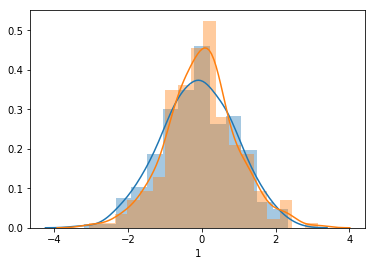

In [10]:
sns.distplot(train['0'])
sns.distplot(train['1'])

In [11]:
columnsToDrop = ['target', 'id']

train_mean_std = train.describe().loc[['mean', 'std']].drop(columns=columnsToDrop, axis=1)

In [12]:
train_mean_std.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
mean,-0.098064,0.001208,0.090680,-0.122248,0.011500,-0.116624,0.006932,0.100988,-0.044960,0.007768,...,0.013052,0.007500,0.000452,0.060276,-0.090308,-0.040728,-0.002132,-0.012540,-0.039904,0.073236
std,0.996063,0.955117,0.968065,0.933001,0.945662,1.081705,1.014091,1.028042,0.893491,1.010694,...,1.027845,1.048169,1.026398,1.048744,1.008657,1.051273,1.065524,0.958744,0.948251,0.924989


In [13]:
train_mean_std = train_mean_std.T
train_mean_std.head()

,mean,std
0,-0.098064,0.996063
1,0.001208,0.955117
2,0.090680,0.968065
3,-0.122248,0.933001
4,0.011500,0.945662


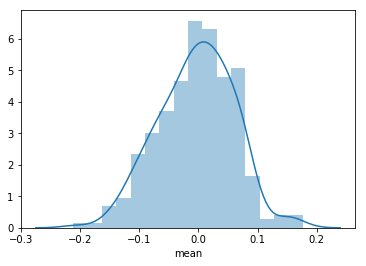

In [14]:
sns.distplot(train_mean_std['mean'])

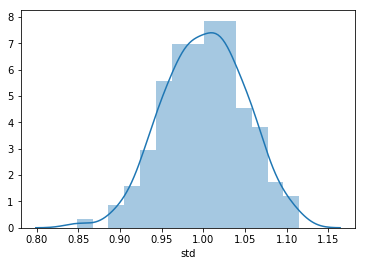

In [15]:
sns.distplot(train_mean_std['std'])

The average is close to 0 and standard deviation is 1 units for most of the features, 
<br>meaning they're scaled already.

---
Let's just fit a model and see.
<br>I'll start with a simple logistic regression.

In [16]:
predictorTrain, predictorTest, targetTrain, targetTest = train_test_split(train[train.columns.drop(columnsToDrop)], train['target'], test_size=0.33, random_state=42)

In [17]:
lr = LogisticRegressionCV()

lr.fit(predictorTrain, targetTrain)
predictions = lr.predict(predictorTest)

r2_score(targetTest, predictions)

-0.31746031746031766

In [18]:
print(accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

0.7590361445783133
[0.75903614 0.        ] [1. 0.] [0.8630137 0.       ] [63 20]


C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
rfc = RandomForestClassifier(n_estimators=10)

rfc.fit(predictorTrain, targetTrain)
predictions = rfc.predict(predictorTest)

r2_score(targetTest, predictions)

-0.31746031746031766

In [20]:
print(accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

0.7590361445783133
[0.7654321 0.5      ] [0.98412698 0.05      ] [0.86111111 0.09090909] [63 20]


In [21]:
lr = LogisticRegressionCV()
#lr = RandomForestClassifier(n_estimators=10)

lr.fit(train[train.columns.drop(columnsToDrop)], train['target'])

predictions = np.int_(lr.predict(test[test.columns.drop('id')]))


submission_data = {'id': test['id'], 'target': predictions}
submission = pd.DataFrame(data=submission_data)

submission.to_csv(path_or_buf=join(overfit_directory, "submission.csv"), index=False)

In [22]:
submission['target'].value_counts()

0    19750
Name: target, dtype: int64

---

All right, my model did really bad.
<br>I'll continue to explore reasons why that could've happened.

In [23]:
lr = LogisticRegressionCV()
#lr = RandomForestClassifier(n_estimators=10)

lr.fit(train[train.columns.drop(columnsToDrop)], train['target'])
predictions = lr.predict(train[train.columns.drop(columnsToDrop)])

print("rs score: ", r2_score(train['target'], predictions))

print("accuracy: ", accuracy_score(train['target'], predictions))

precision, recall, fscore, support = precision_recall_fscore_support(train['target'], predictions)
print(precision, recall, fscore, support)

rs score:  -0.36612021857923516
accuracy:  0.732
[0.732 0.   ] [1. 0.] [0.84526559 0.        ] [183  67]


C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


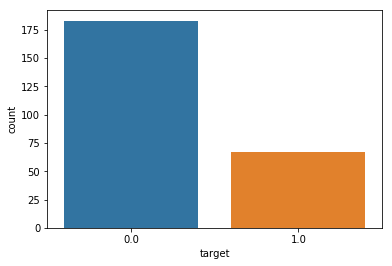

In [24]:
sns.countplot(x='target', data=train)

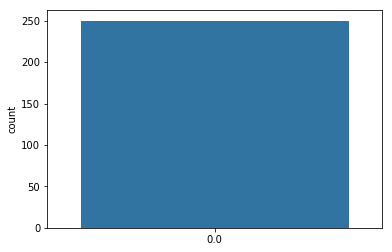

In [25]:
sns.countplot(predictions)

In [26]:
train['target'].value_counts()

0.0    183
1.0     67
Name: target, dtype: int64

I observe that my model predicts '0' all the time. 
<br>Maybe it's because I have a class imbalance.
<br>Class '0' values are almost 3 times as much as class '1' values.
<br>So I'll randomly sample 67 Class '0' values and let the model train on them.

In [27]:
oneCount = train[train['target'] == 1]['target'].count()

oneCount = 45

tempPredictorDF = train[train['target'] == 0].sample(2*oneCount)
tempPredictorDF = tempPredictorDF.append(train[train['target'] == 1].sample(oneCount))

tempPredictorDF.drop_duplicates().reset_index(drop=True)

predictors = tempPredictorDF[tempPredictorDF.columns.drop(columnsToDrop)]
target = tempPredictorDF['target']

In [28]:
lr = LogisticRegressionCV()
#lr = RandomForestClassifier(n_estimators=10)

lr.fit(predictors, target)
predictions = lr.predict(predictors)

print("rs score: ", r2_score(target, predictions))

print("accuracy: ", accuracy_score(target, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(target, predictions)
print(precision, recall, fscore, support)

rs score:  1.0
accuracy:  1.0
[1. 1.] [1. 1.] [1. 1.] [90 45]


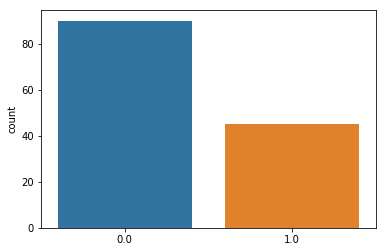

In [29]:
sns.countplot(predictions)

Now it seems to work well for both the classes.
<br>But let's see how well it scales.

I'll just let it go nuts on the entire train data.
<br>This will have '0' class recors it hasn't seen before.
<br>I wish I had unseen '1' class records as well, but we're short as it is.
<br>Nevertheless, for the time being, let's see.

In [30]:
# This will fetch those train records which weren't used in training before.
testSample = pd.concat([train, tempPredictorDF]).drop_duplicates(keep=False)

testPredictors = testSample[testSample.columns.drop(columnsToDrop)]
testTarget = testSample['target']

fullPredictions = lr.predict(testPredictors)

print("rs score: ", r2_score(testTarget, fullPredictions))

print("accuracy: ", accuracy_score(testTarget, fullPredictions))

precision, recall, fscore, support = precision_recall_fscore_support(testTarget, fullPredictions)
print(precision, recall, fscore, support)

rs score:  -0.7424242424242427
accuracy:  0.7304347826086957
[0.86046512 0.34482759] [0.79569892 0.45454545] [0.82681564 0.39215686] [93 22]


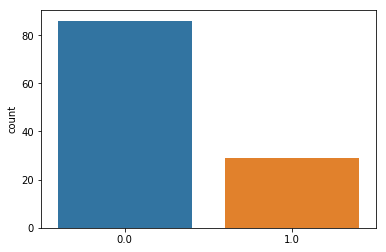

In [31]:
sns.countplot(fullPredictions)

In [32]:
testTarget.value_counts()

0.0    93
1.0    22
Name: target, dtype: int64

The precision and recall for class '1' is still horrible, the model still wasn't able to learn

---
Alright, with the imbalanced dataset I should've done oversampling instead of undersampling because my dataset is small.
<br>Nevertheless, I'll try biasing my model towards the minority class by using the class_weight attribute.
<br>If that doesn't do the trick, I'll use the imblearn's SMOTE method to balance out the classes.

In [33]:
lr = LogisticRegressionCV(class_weight='balanced')
#lr = RandomForestClassifier(n_estimators=10)

lr.fit(predictors, target)
predictions = lr.predict(testPredictors)

print("rs score: ", r2_score(testTarget, predictions))

print("accuracy: ", accuracy_score(testTarget, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(testTarget, predictions)
print(precision, recall, fscore, support)

rs score:  -0.6862170087976542
accuracy:  0.7391304347826086
[0.84615385 0.33333333] [0.82795699 0.36363636] [0.83695652 0.34782609] [93 22]


Biasing didn't help. So let's try imblearn.

---

In [34]:
predictors = train[train.columns.drop(columnsToDrop)]
target = train['target']

smote = SMOTE('minority')
syntheticPredictors, syntheticTarget = smote.fit_sample(predictors, target)

syntheticPredictors.shape, syntheticTarget.shape

((366, 300), (366,))

In [35]:
syntheticTarget.value_counts()

0.0    183
1.0    183
Name: target, dtype: int64

Imbalanced -learn perfectly equalized the class categories.
<br>Let's see how the model performs now.

In [36]:
syntheticPredictorsTrain, syntheticPredictorsTest, syntheticTargetTrain, syntheticTargetTest = train_test_split(syntheticPredictors, syntheticTarget, test_size=0.33, random_state=42)

In [37]:
#lr = LogisticRegressionCV()
lr = RandomForestClassifier(n_estimators=100)

lr.fit(syntheticPredictorsTrain, syntheticTargetTrain)
predictions = lr.predict(syntheticPredictorsTest)

print("rs score: ", r2_score(syntheticTargetTest, predictions))

print("accuracy: ", accuracy_score(syntheticTargetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(syntheticTargetTest, predictions)
print(precision, recall, fscore, support)

rs score:  0.6361399671951886
accuracy:  0.9090909090909091
[0.875      0.94736842] [0.94915254 0.87096774] [0.91056911 0.90756303] [59 62]


Alright! That is the highest precision, recall, accuracy score I've seen for this data.
<br>Let's see how well it fares.

In [38]:
lr = LogisticRegressionCV()
#lr = RandomForestClassifier(n_estimators=100)

lr.fit(syntheticPredictors, syntheticTarget)

predictions = np.int_(lr.predict(test[test.columns.drop('id')]))


submission_data = {'id': test['id'], 'target': predictions}
submission = pd.DataFrame(data=submission_data)

submission.to_csv(path_or_buf=join(overfit_directory, "submission.csv"), index=False)

---
Turns out, it still flops.
<br>I'm thinking it's because it learned well about the synthetic points we added, but the real points were still learnt badly.

<br>Just to observe this I'll separate the validation set before synthesizing and I'll train the model on the synthesized train set.
<br>Then I can see how our model fares with the actual categories.

In [39]:
predictorTrain, predictorTest, targetTrain, targetTest = train_test_split(train[train.columns.drop(columnsToDrop)], train['target'], test_size=0.33, random_state=42)

smote = SMOTE('minority')
syntheticPredictors, syntheticTarget = smote.fit_sample(predictorTrain, targetTrain)

syntheticPredictors.shape, syntheticTarget.shape

((240, 300), (240,))

In [40]:
lr = LogisticRegressionCV()
#lr = RandomForestClassifier(n_estimators=10)

lr.fit(syntheticPredictors, syntheticTarget)
predictions = lr.predict(predictorTest)

print("rs score: ", r2_score(targetTest, predictions))

print("accuracy: ", accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

rs score:  -0.31746031746031766
accuracy:  0.7590361445783133
[0.82089552 0.5       ] [0.87301587 0.4       ] [0.84615385 0.44444444] [63 20]


As Expected, it is still bad.
<br>The precision, recall, accuracy scores with the synthetic dataset show promising results,
<br>but in reality the model didn't do that well.

---
Alright, I'll try using another model.
<br>Something like Stochastic Gradient Descent Classifier, I've heard it performs well.
<br>I could also make the different models vote.
<br>Let's see.

In [41]:
sgd = SGDClassifier()

sgd.fit(syntheticPredictors, syntheticTarget)
predictions = sgd.predict(predictorTest)

print("rs score: ", r2_score(targetTest, predictions))

print("accuracy: ", accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

rs score:  -0.8444444444444448
accuracy:  0.6626506024096386
[0.79661017 0.33333333] [0.74603175 0.4       ] [0.7704918  0.36363636] [63 20]


In [42]:
gbr = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5)


gbr.fit(syntheticPredictors, syntheticTarget)
predictions = gbr.predict(predictorTest)

print("rs score: ", r2_score(targetTest, predictions))

print("accuracy: ", accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

rs score:  -0.3833333333333335
accuracy:  0.7469879518072289
[0.77631579 0.42857143] [0.93650794 0.15      ] [0.84892086 0.22222222] [63 20]


Alright, hyper-parameter optimization could give better results.
<br>But I'm thinking the problem isn't with the models.

---
Let me try voting for a change.

In [43]:
#predictorTrain, predictorTest, targetTrain, targetTest = train_test_split(train[train.columns.drop(columnsToDrop)], train['target'], test_size=0.33, random_state=42)

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42, oob_score=True) 
gradient_clf =  GradientBoostingClassifier(subsample = 0.75, random_state=42)
ada_boost_clf = AdaBoostClassifier(learning_rate=0.9, random_state=42)
svc_clf = SVC(probability=True, random_state=42)
logitcv_clf = LogisticRegressionCV(solver='lbfgs', random_state=42)
sgd_clg = SGDClassifier(loss='modified_huber', random_state=42)


voting_clf = VotingClassifier(estimators=[('rfc', forest_clf), ('gbc', gradient_clf), ('abc', ada_boost_clf), ('svc', svc_clf),
                                         ('lcv', logitcv_clf), ('sgd', sgd_clg)], voting='hard')
voting_clf.fit(syntheticPredictors, syntheticTarget)


predictions = voting_clf.predict(predictorTest)

print("rs score: ", r2_score(targetTest, predictions))

print("accuracy: ", accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

rs score:  -0.3833333333333335
accuracy:  0.7469879518072289
[0.77631579 0.42857143] [0.93650794 0.15      ] [0.84892086 0.22222222] [63 20]


Voting seems to fail as well.
<br>Let me try One Class Classifier

In [44]:
predictorTrain, predictorTest, targetTrain, targetTest = train_test_split(train[train.columns.drop(columnsToDrop)], train['target'], test_size=0.33, random_state=42)

trainNormal = predictorTrain[targetTrain == 0]
trainOutliers = predictorTrain[targetTrain == 1]

outlierProportion = len(trainOutliers) / len(trainNormal)


ocsvm = OneClassSVM(kernel='rbf', nu=outlierProportion, gamma=0.000001)
ocsvm.fit(trainNormal)

predictions = ocsvm.predict(predictorTest)
predictions = (predictions + 1) / 2

print("r2 score: ", r2_score(targetTest, predictions))

print("accuracy: ", accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

r2 score:  -2.030158730158731
accuracy:  0.4457831325301205
[0.71794872 0.20454545] [0.44444444 0.45      ] [0.54901961 0.28125   ] [63 20]


In [45]:
pred = pd.Series(predictions)
pred.value_counts()

1.0    44
0.0    39
dtype: int64

This usually works, but it's still bad in our case.
<br>One of the reasons could be that I've used all the features for training.
<br>OneClass SVM requires class separability. This means that data points belonging to one particular class should be clustered, while those of another class are scattered like outliers.
<br>Comparing the classes with two features at a time, some pairs will show that separability and some won't.
<br>Those that don't should be removed, which I haven't done.

Refer to the images in: https://towardsdatascience.com/outlier-detection-with-one-class-svms-5403a1a1878c
<br>Or the explanation below.

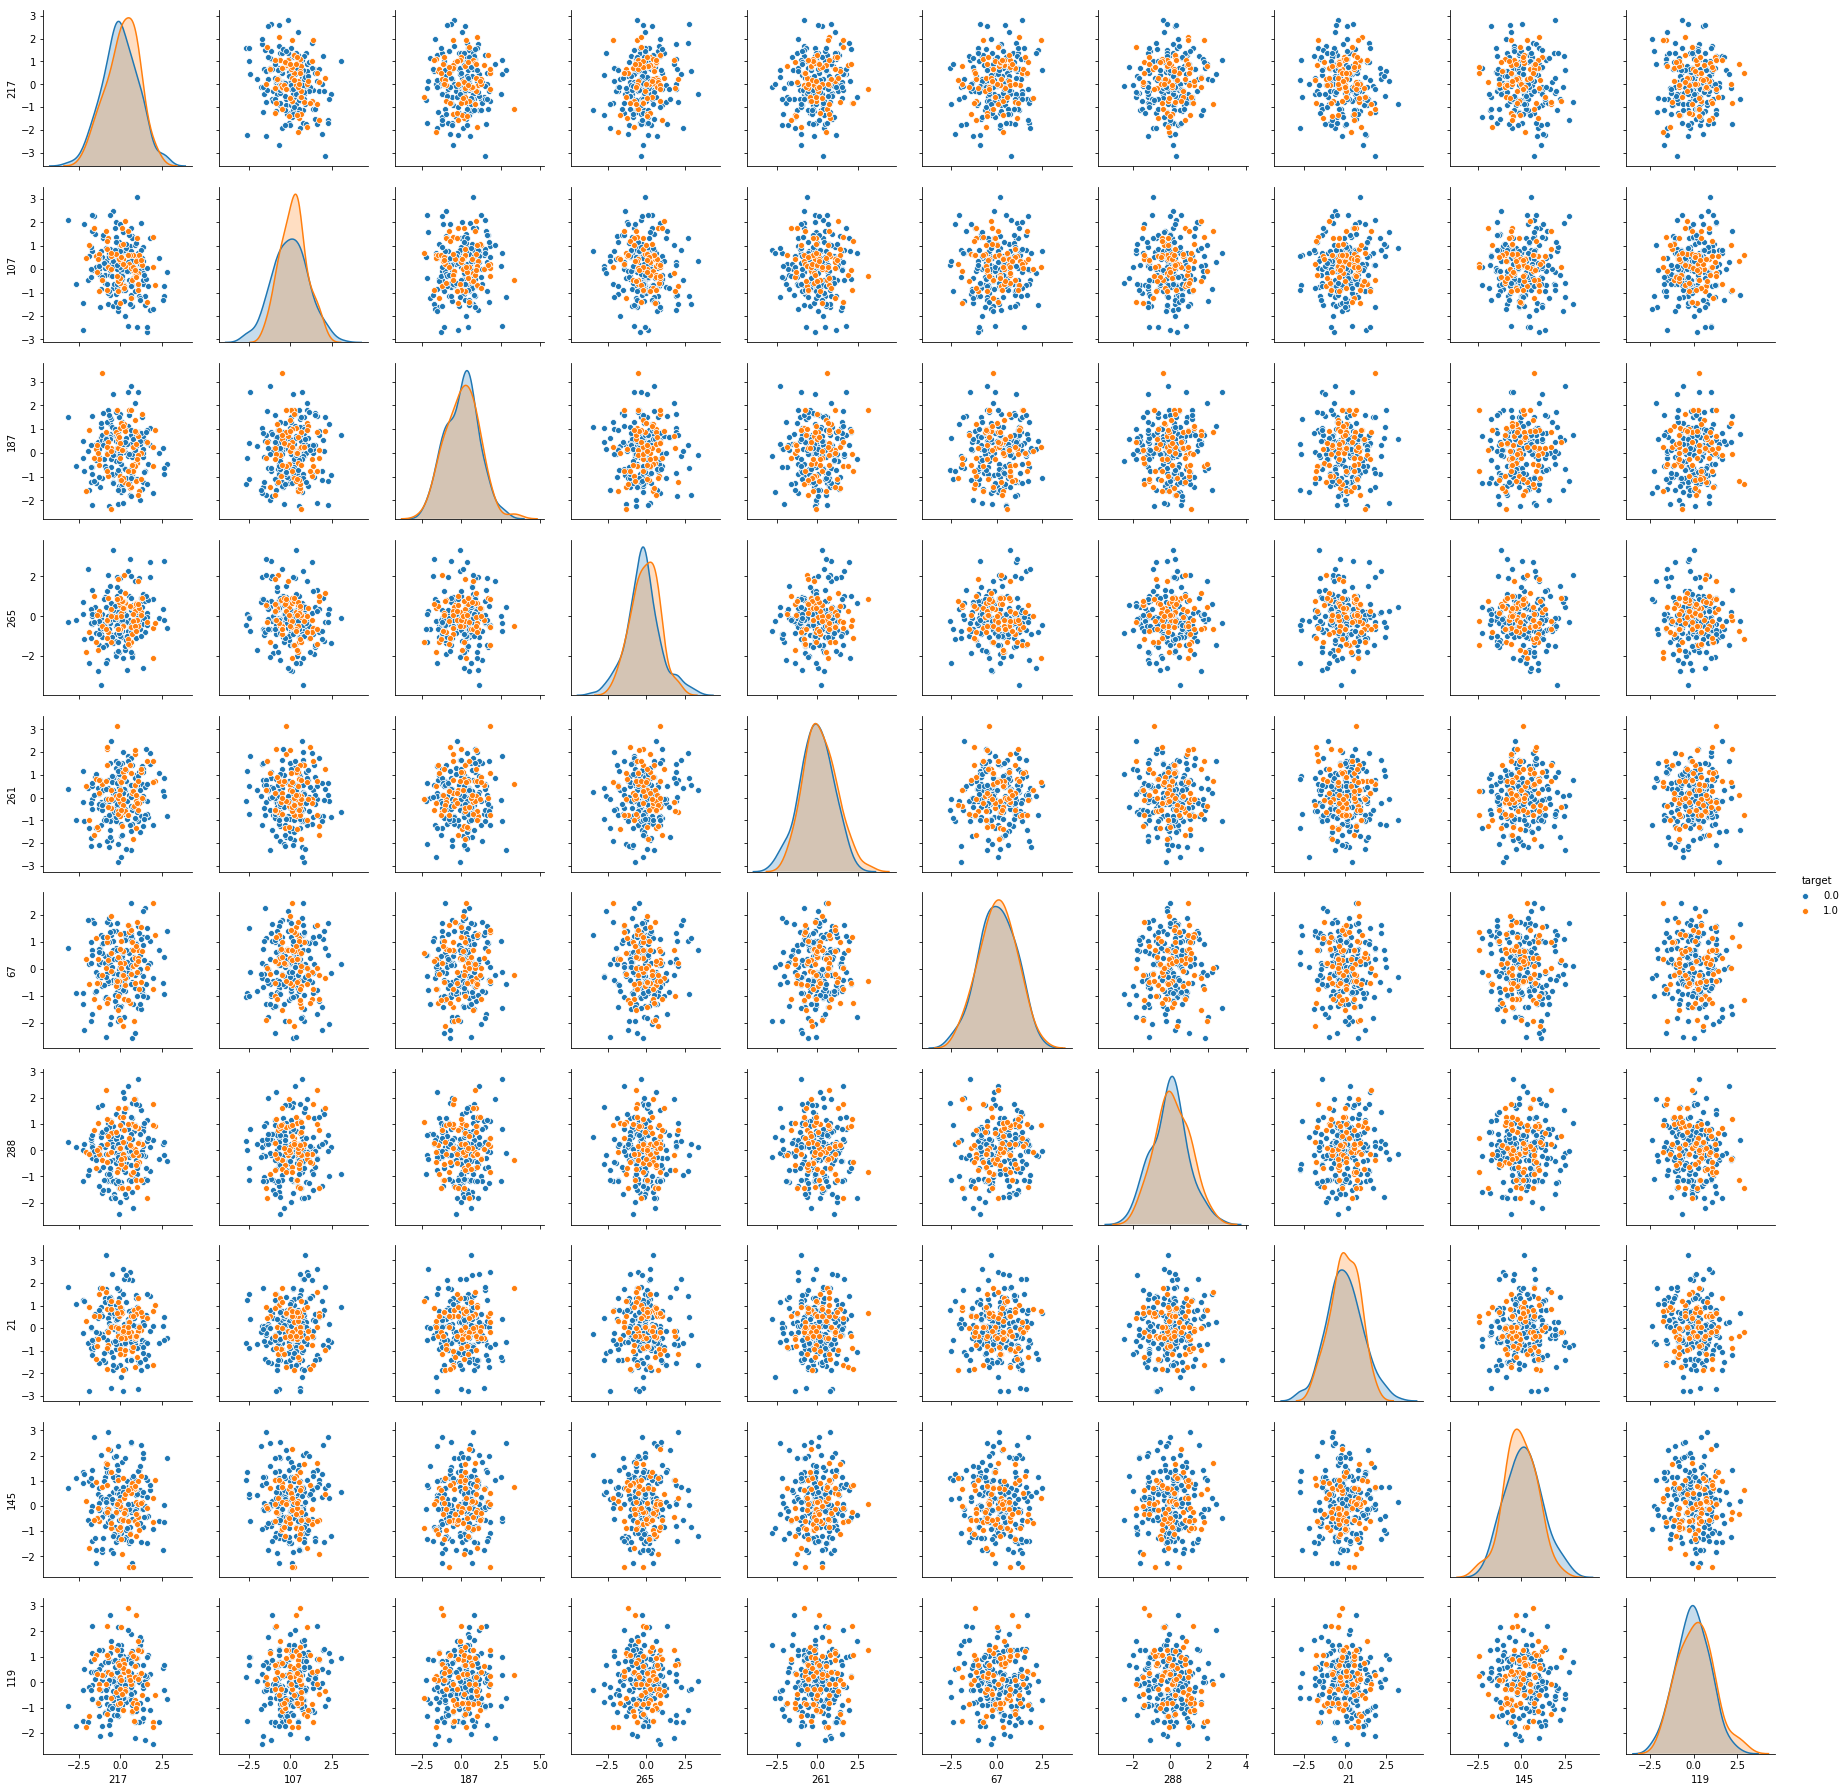

In [46]:
columnsToCompare = train.columns.drop(columnsToDrop).to_series().sample(n=10)

sns.pairplot(train, x_vars=columnsToCompare, y_vars=columnsToCompare, hue='target')

<br>The points of each class seem to overlap with each other.
<br>We'd expect some points of the minority class to lie outside the cluster so we can treat them as outliers.
<br>But there seems to be no clear separability between the classes. And that's probably why OneClass SVM fails.
<br>That's also why the predictions are distributed evenly among the classes:
<br>1  -  44
<br>0  -  39

---
Alright! Here's another approach!
<br>I'll apply LDA to reduce dimensionality.
<br>The great thing here is: LDA tries to maximize class separability while reducing dimensions, 
<br>which is exactly what we need for OneClass SVM to work.

In [47]:
lda = LDA(solver='svd')
reducedTrain = lda.fit_transform(train[train.columns.drop(columnsToDrop)], train['target'])

In [48]:
reducedTrain.shape

(250, 1)

In [49]:
predictorTrain, predictorTest, targetTrain, targetTest = train_test_split(reducedTrain, train['target'], test_size=0.33, random_state=42)

trainNormal = predictorTrain[targetTrain == 0]
trainOutliers = predictorTrain[targetTrain == 1]

outlierProportion = len(trainOutliers) / len(trainNormal)


ocsvm = OneClassSVM(kernel='rbf', nu=outlierProportion, gamma=0.000001)
ocsvm.fit(trainNormal)

predictions = ocsvm.predict(predictorTest)
predictions = (predictions + 1) / 2

print("r2 score: ", r2_score(targetTest, predictions))

print("accuracy: ", accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

r2 score:  -2.1619047619047627
accuracy:  0.42168674698795183
[0.63636364 0.        ] [0.55555556 0.        ] [0.59322034 0.        ] [63 20]


In [51]:
# reducedTrainDF = pd.DataFrame(data={'reducedFeature': reducedTrain.reshape(250), 'target': train['target']})
# sns.pairplot(reducedTrainDF, hue='target')

---
Although, class separability is now very good.
<br>Let's try voting once again, with the LDA reduced data.

In [52]:
predictorTrain, predictorTest, targetTrain, targetTest = train_test_split(reducedTrain, reducedTrainDF['target'], test_size=0.33, random_state=42)

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42, oob_score=True) 
gradient_clf =  GradientBoostingClassifier(subsample = 0.75, random_state=42)
ada_boost_clf = AdaBoostClassifier(learning_rate=0.9, random_state=42)
svc_clf = SVC(probability=True, random_state=42)
logitcv_clf = LogisticRegressionCV(solver='lbfgs', random_state=42)
sgd_clg = SGDClassifier(loss='modified_huber', random_state=42)


voting_clf = VotingClassifier(estimators=[('rfc', forest_clf), ('gbc', gradient_clf), ('abc', ada_boost_clf), ('svc', svc_clf),
                                         ('lcv', logitcv_clf), ('sgd', sgd_clg)], voting='hard')
voting_clf.fit(predictorTrain, targetTrain)


predictions = voting_clf.predict(predictorTest)

print("rs score: ", r2_score(targetTest, predictions))

print("accuracy: ", accuracy_score(targetTest, predictions))

precision, recall, fscore, support = precision_recall_fscore_support(targetTest, predictions)
print(precision, recall, fscore, support)

rs score:  1.0
accuracy:  1.0
[1. 1.] [1. 1.] [1. 1.] [63 20]


Woah! This is insane.
<br>I must've completely overfit it.
<br>But let's submit it once and check.

In [53]:
lda = LDA(solver='svd')
reducedTrain = lda.fit_transform(train[train.columns.drop(columnsToDrop)], train['target'])
reducedTest = lda.transform(test[train.columns.drop(columnsToDrop)])

voting_clf = VotingClassifier(estimators=[('rfc', forest_clf), ('gbc', gradient_clf), ('abc', ada_boost_clf), ('svc', svc_clf),
                                         ('lcv', logitcv_clf), ('sgd', sgd_clg)], voting='hard')
voting_clf.fit(reducedTrain, train['target'])

predictions = voting_clf.predict(reducedTest)

submission_data = {'id': test['id'], 'target': predictions}
submission = pd.DataFrame(data=submission_data)

submission.to_csv(path_or_buf=join(overfit_directory, "submission.csv"), index=False)

Damn right, I overfit it. LOL

---
Okay, I've seen a few solutions.
<br>The top two place holders are using leaderboard probing. If you think about it, in a way, we all are.
<br>But that's not what I want to learn now.

---
The fourth place solution doesn't use leaderboard probing.
<br>The author himself admits that <i>"the overall performance of my kernels is a combination of pure chance and my determination to advance on Public LB."</i>
<br>This doesn't feel right at all.
<br>I've learned some good techniques to handle imbalance in datasets and tried various approaches. I think that's better and more relevant.
<br>If I too iteratively try to find the best parameter combinations that maximize my model's performance, maybe I'll score more.

---
Anyways, this is what can be done.
<br>1: Use a logistic regression model, put it inside a GridSearchCV model.
<br>2: Now use this is as an estimator in a Recursive Feature Elimination model. (RFE)
<br>3: This model gives the best features for a dataset.
<br>4: Now fit this reduced feature set in a new GridSearchCV that can have the same estimator as the previous Feature Elimination model (feature_selector.estimator_) i.e Logistic Regression model. 

Do steps 3-4 recursively with subsets of the dataset.
<br>Have some threshold for the metrics you're using for scoring.
<br>If the current models matches the threshold, have it predict on the transformed test data (RFE applied)
<br>At the end take average of those predictions.

Note: This is not my original solution, as mentioned before I inspired from the 4th place solution.

In [54]:
rfe_min_features = 12
rfe_step = 15
rfe_cv = 20
grid_search_cv = 20
sss_n_splits = 20           
sss_test_size = 0.35
random_seed = 234587
r2_threshold = 0.185

def scoring_roc_auc(y, y_pred):
    try:
        return roc_auc_score(y, y_pred)
    except:
        return 0.5

scorer = make_scorer(scoring_roc_auc)

def with_statistics(X):
    statistics = pd.DataFrame()
    statistics['mean']   = X.mean(axis=1)
    statistics['kurt']   = X.kurt(axis=1)
    statistics['mad']    = X.mad(axis=1)
    statistics['median'] = X.median(axis=1)
    statistics['max']    = X.max(axis=1)
    statistics['min']    = X.min(axis=1)
    statistics['skew']   = X.skew(axis=1)
    statistics['sem']    = X.sem(axis=1)
    
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(5, n_jobs=-1)
    neigh.fit(X)

    dists, _ = neigh.kneighbors(X, n_neighbors=5)
    dists = np.delete(dists, 0, 1)
    statistics['minDist'] = dists.mean(axis=1)
    statistics['maxDist'] = dists.max(axis=1)
    statistics['meanDist'] = dists.min(axis=1)

    X = pd.concat([X, statistics], axis=1)
    return X


# scale using RobustScaler
'''
scaler = RobustScaler()
scaledTrain = pd.DataFrame(scaler.fit_transform(train[train.columns.drop(columnsToDrop)]))
scaledTest = pd.DataFrame(scaler.transform(test[test.columns.drop('id')]))


scaledTrain = with_statistics(scaledTrain)
scaledTest = with_statistics(scaledTest)
scaledTrain['target'] = train['target']
'''
train_X = train[train.columns.drop(columnsToDrop)].values
test = test[test.columns.drop('id')].values
data = RobustScaler().fit_transform(np.concatenate((train_X, test), axis=0))
train_X = data[:train_X.shape[0]]
test = data[train_X.shape[0]:]


train_X = with_statistics(pd.DataFrame(train_X))
train_y = train['target']
scaledTest = with_statistics(pd.DataFrame(test))

model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', C=0.31, penalty='l1')

param_grid = {
        'C'     : [0.2, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37],
        'tol'   : [0.0001, 0.00011, 0.00009]
    }

grid_search = GridSearchCV(model, param_grid=param_grid, verbose=0, n_jobs=-1, scoring=scorer, cv=20)
grid_search.fit(train_X, train_y)

# define recursive elimination feature selector
feature_selector = RFECV(grid_search.best_estimator_, min_features_to_select=rfe_min_features, scoring=scorer, step=rfe_step, verbose=0, cv=20, n_jobs=-1)

In [55]:
predictions = pd.DataFrame()
for train_index, val_index in StratifiedShuffleSplit(n_splits=sss_n_splits, test_size=sss_test_size, random_state=random_seed).split(train_X, train_y):
    predictorTrain, predictorTest = train_X.iloc[train_index], train_X.iloc[val_index]
    targetTrain, targetTest = train_y[train_index], train_y[val_index]

    feature_selector.fit(predictorTrain, targetTrain)


    predictor_important_features = feature_selector.transform(predictorTrain)
    validation_important_features = feature_selector.transform(predictorTest)
    test_important_features = feature_selector.transform(scaledTest)

    # run grid search to find the best Lasso parameters for this subset of training data and subset of features 
    grid_search_predictor = GridSearchCV(feature_selector.estimator_, param_grid=param_grid, verbose=0, n_jobs=-1, scoring=scorer, cv=grid_search_cv)
    grid_search_predictor.fit(predictor_important_features, targetTrain)

    preds = grid_search_predictor.best_estimator_.predict_proba(validation_important_features)[:,1]
    val_r2 = r2_score(targetTest, preds)
    print("rs score: ", val_r2)
    print("ROCAUC score: ", roc_auc_score(targetTest, preds))
    print("------------------------------------------------------")
    
    if val_r2 > r2_threshold:
        prediction = grid_search_predictor.best_estimator_.predict_proba(test_important_features)[:,1]
        predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
    
mean_pred = pd.DataFrame(predictions.mean(axis=1))

rs score:  -0.023076861839935736
ROCAUC score:  0.72265625
------------------------------------------------------
rs score:  -0.1551974493297974
ROCAUC score:  0.7109375
------------------------------------------------------
rs score:  -0.21984826571989258
ROCAUC score:  0.7109375
------------------------------------------------------
rs score:  -0.06401984549504403
ROCAUC score:  0.7604166666666667
------------------------------------------------------
rs score:  -0.11470978668260035
ROCAUC score:  0.6634114583333333
------------------------------------------------------
rs score:  -0.0906946377552873
ROCAUC score:  0.7220052083333334
------------------------------------------------------
rs score:  -0.14223977031946844
ROCAUC score:  0.7057291666666667
------------------------------------------------------
rs score:  -0.05806291806646735
ROCAUC score:  0.71875
------------------------------------------------------
rs score:  -0.10059328175734805
ROCAUC score:  0.6946614583333334
----

In [56]:
mean_pred.index += 250
mean_pred.columns = ['target']

In [57]:
mean_pred.head()

,target


In [61]:
submission.head()dd

,id,target
0,250,0.0
1,251,1.0
2,252,0.0
3,253,0.0
4,254,1.0


In [66]:
test.shape

(19750, 300)

In [69]:
# train, test = load_overfit_data(overfit_directory)

In [70]:
predictions = grid_search_predictor.best_estimator_.predict(test_important_features)

submission_data = {'id': test['id'], 'target': predictions}
submission = pd.DataFrame(data=submission_data)

submission.to_csv(path_or_buf=join(overfit_directory, "submission.csv"), index=False)

1: Robust Scaler
2: Use a logistic regression model.
3: GridSearchCV for parameter tuning.
4: Recursive Feature Elimination model.
5: A new GridSearchCV for predictions.